In [2]:
from re import L
import jax
import jax.numpy as jnp
import numpy as np
%load_ext autoreload
%autoreload 2

from src.models.base import ModelConfig
from src.models.rnn import ElmanRNN, LSTM, UnitaryRNN
from src.models.lru import LinearRecurrentUnit
from src.data.copy_dataset import CopyDataset

num_classes = 10
model_cfg = ModelConfig(input_dim=num_classes, output_dim=num_classes, hidden_dim=32)
# model = ElmanRNN(model_cfg, nonlinearity="relu")
# model = LSTM(model_cfg)
# model = LinearRecurrentUnit(model_cfg)
model = UnitaryRNN(model_cfg)
params = model.initialize(jax.random.PRNGKey(0))

dataset = CopyDataset(min_lag=1000, max_lag=1000, batch_size=2, num_classes=num_classes, seq_length=8)
inputs, targets, mask = dataset()
inputs_oh = jax.nn.one_hot(inputs, num_classes, dtype=jnp.float32)
print("inputs one-hot:", inputs_oh.shape)
print("mask:", mask.shape)


inputs one-hot: (2, 1016, 10)
mask: (2, 1016)


In [3]:
outputs, tensors, summary = model.analyze_batch(
    params,
    inputs_oh,
    mask,
)

print("frobenius norms shape:", summary.frobenius_norms.shape)
print("active fraction shape:", summary.nonlinearity_active_fraction.shape)
print("scaling shape:", summary.nonlinearity_scaling.shape)

print("mean frobenius:", float(summary.frobenius_norms.mean()))
print("mean active fraction:", float(summary.nonlinearity_active_fraction.mean()))
print("mean scaling:", float(summary.nonlinearity_scaling.mean()))




frobenius norms shape: (2, 1016)
active fraction shape: (2, 1016)
scaling shape: (2, 1016, 32)
mean frobenius: 0.044677734375
mean active fraction: 0.9671505689620972
mean scaling: 0.84375


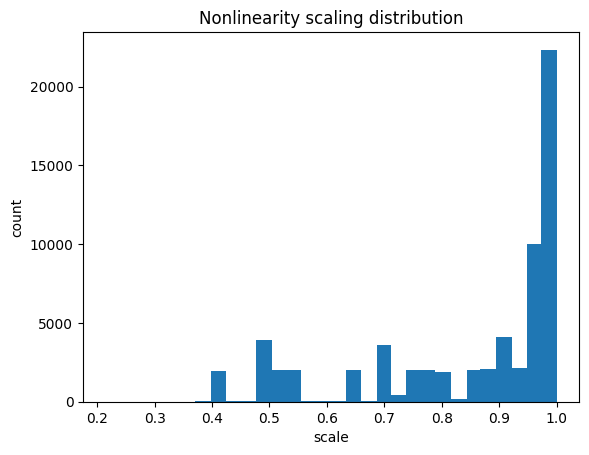

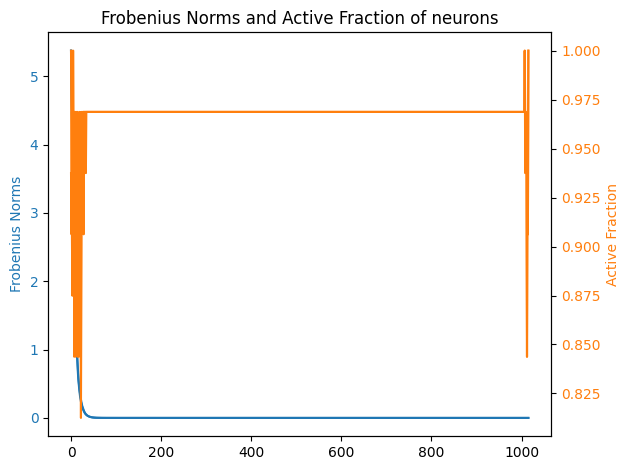

In [4]:
import matplotlib.pyplot as plt

flatten = np.ravel(np.array(summary.nonlinearity_scaling))
plt.hist(flatten, bins=30)
plt.title("Nonlinearity scaling distribution")
plt.xlabel("scale")
plt.ylabel("count")
plt.show()

fig, ax1 = plt.subplots()

ax1.plot(summary.frobenius_norms.T,color='tab:blue')
ax1.set_ylabel('Frobenius Norms', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(summary.nonlinearity_active_fraction.T, color='tab:orange')
ax2.set_ylabel('Active Fraction', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Frobenius Norms and Active Fraction of neurons')
fig.tight_layout()

In [28]:
%pdb

Automatic pdb calling has been turned ON


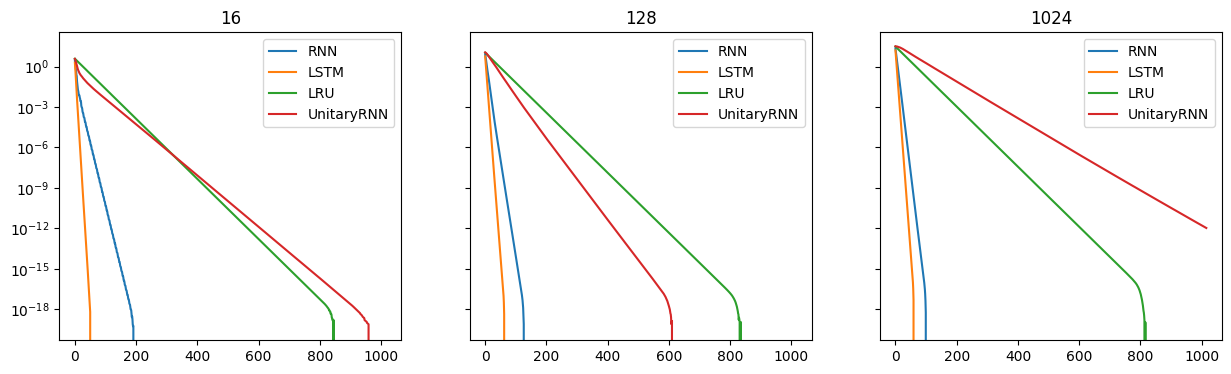

In [8]:
hidden_dims = [16,128,1024]
fig, ax = plt.subplots(1,len(hidden_dims),figsize=(5*len(hidden_dims),4),sharey=True)
for i,hidden_dim in enumerate(hidden_dims):
    model_cfg = ModelConfig(input_dim=num_classes, output_dim=num_classes, hidden_dim=hidden_dim)

    dataset = CopyDataset(min_lag=1000, max_lag=1000, batch_size=2, num_classes=num_classes, seq_length=8)
    inputs, targets, mask = dataset()
    inputs_oh = jax.nn.one_hot(inputs, num_classes, dtype=jnp.float32)
    all_norms = []
    for model_class in [ElmanRNN, LSTM, LinearRecurrentUnit, UnitaryRNN]:
        model = model_class(model_cfg)
        params = model.initialize(jax.random.PRNGKey(0))

        outputs, tensors, summary = model.analyze_batch(
                params,
                inputs_oh,
                mask,
            )
        norms = np.mean(summary.frobenius_norms,axis=0)
        all_norms.append(norms)
    labels = ["RNN","LSTM","LRU","UnitaryRNN"]
    ax[i].set_title(hidden_dim)
    for j,norm in enumerate(all_norms):
        ax[i].plot(norm,label=labels[j])

    ax[i].legend()
    ax[i].set_yscale('log')